## Sparse susieR Speed Analysis

In [13]:
library(Matrix)
library(microbenchmark)
library(ggplot2)

### 0. simulate a centered X and a binary vector Y

In [9]:
centered_sparse_mat = function(sparsity, N, P){
  set.seed(1)
  nonzero = sample(c(1,-1), size=round(N*P*(1-sparsity)), replace=TRUE, prob=c(.5,.5))
  testMat = sample(c(nonzero, rep(0,N*P-length(nonzero))))
  testMat = matrix(testMat, N, P)
  return(testMat)     
}

In [11]:
N = 3000
P = 1000
Y = sample(c(1,0), size=N, replace=TRUE, prob=c(.2,.8))
X_list = list()
X_sparse_list = list()
for (s in 1:7){
    X_list[[s]] = centered_sparse_mat(s/10+0.2, N, P)
    X_sparse_list[[s]] = as(X_list[[s]], 'dgCMatrix')
}
X_0.95 = centered_sparse_mat(0.95, N, P)
X_sparse_0.95 = as(X_0.95, 'dgCMatrix')
X_0.99 = centered_sparse_mat(0.99, N, P)
X_sparse_0.99 = as(X_0.99, 'dgCMatrix')

### 1. single_effect_regression
Added two fixes in this function.

In [22]:
#code from susie
single_effect_regression = function(Y,X,sa2=1,s2=1,optimize_sa2=FALSE){
  d = colSums(X^2)
  V = s2*sa2 # scale by residual variance
  betahat = as.matrix((1/d) * t(X) %*% Y)   ### Add as.matrix()
  shat2 = s2/d
  if(optimize_sa2){
    if(loglik.grad(0,Y,X,s2)<0){
      V=0
    } else {
      V.u=uniroot(negloglik.grad.logscale,c(-10,10),extendInt = "upX",Y=Y,X=X,s2=s2)
      V = exp(V.u$root)
    }
  }
  lbf = dnorm(betahat,0,sqrt(V+shat2),log=TRUE) - dnorm(betahat,0,sqrt(shat2),log=TRUE)
  #log(bf) on each SNP
  
  maxlbf = max(lbf)
  w = exp(lbf-maxlbf) # w is proportional to BF, but subtract max for numerical stability
  alpha = w/sum(w) # posterior prob on each SNP
  
  post_var = (1/V + d/s2)^(-1) # posterior variance
  post_mean = (d/s2) * post_var * betahat
  post_mean2 = post_var + post_mean^2 # second moment
  loglik = maxlbf + log(mean(w)) + sum(dnorm(Y,0,sqrt(s2),log=TRUE))
  return(list(alpha=alpha,mu=post_mean,mu2 = post_mean2,lbf=lbf,sa2=V/s2, loglik = loglik))
}

loglik.grad = function(V,Y,X,s2){
  d = colSums(X^2)
  betahat = as.matrix((1/d) * t(X) %*% Y) ### Add as.matrix()
  shat2 = s2/d
  
  lbf = dnorm(betahat,0,sqrt(V+shat2),log=TRUE) - dnorm(betahat,0,sqrt(shat2),log=TRUE)
  #log(bf) on each SNP
  
  maxlbf = max(lbf)
  w = exp(lbf-maxlbf) # w =BF/BFmax
  alpha = w/sum(w)
  sum(alpha*lbf.grad(V,shat2,betahat^2/shat2))
}

negloglik.logscale = function(lV, Y,X,s2){-loglik(exp(lV),Y,X,s2)}
negloglik.grad.logscale = function(lV,Y,X,s2){-exp(lV)*loglik.grad(exp(lV),Y,X,s2)}

lbf.grad = function(V,shat2,T2){
  0.5* (1/(V+shat2)) * ((shat2/(V+shat2))*T2-1)
}

lbf = function(V,shat2,T2){
  0.5*log(shat2/(V+shat2)) + 0.5*T2*(V/(V+shat2))
}

In [41]:
single_effect_regression_speed_sparse = microbenchmark(
    dense_speed_0.3 = single_effect_regression(Y, X_list[[1]]),
    sparse_speed_0.3 = single_effect_regression(Y, X_sparse_list[[1]]),
    
    dense_speed_0.4 = single_effect_regression(Y, X_list[[2]]),
    sparse_speed_0.4 = single_effect_regression(Y, X_sparse_list[[2]]),
    
    dense_speed_0.5 = single_effect_regression(Y, X_list[[3]]),
    sparse_speed_0.5 = single_effect_regression(Y, X_sparse_list[[3]]),
    
    dense_speed_0.6 = single_effect_regression(Y, X_list[[4]]),
    sparse_speed_0.6 = single_effect_regression(Y, X_sparse_list[[4]]),
    
    dense_speed_0.7 = single_effect_regression(Y, X_list[[5]]),
    sparse_speed_0.7 = single_effect_regression(Y, X_sparse_list[[5]]),
    
    dense_speed_0.8 = single_effect_regression(Y, X_list[[6]]),
    sparse_speed_0.8 = single_effect_regression(Y, X_sparse_list[[6]]),
    
    dense_speed_0.9 = single_effect_regression(Y, X_list[[7]]),
    sparse_speed_0.9 = single_effect_regression(Y, X_sparse_list[[7]]),
    
    dense_speed_0.95 = single_effect_regression(Y, X_0.95),
    sparse_speed_0.95 = single_effect_regression(Y, X_sparse_0.95),
    
    dense_speed_0.99 = single_effect_regression(Y, X_0.99),
    sparse_speed_0.99 = single_effect_regression(Y, X_sparse_0.99),
    
    times=20)

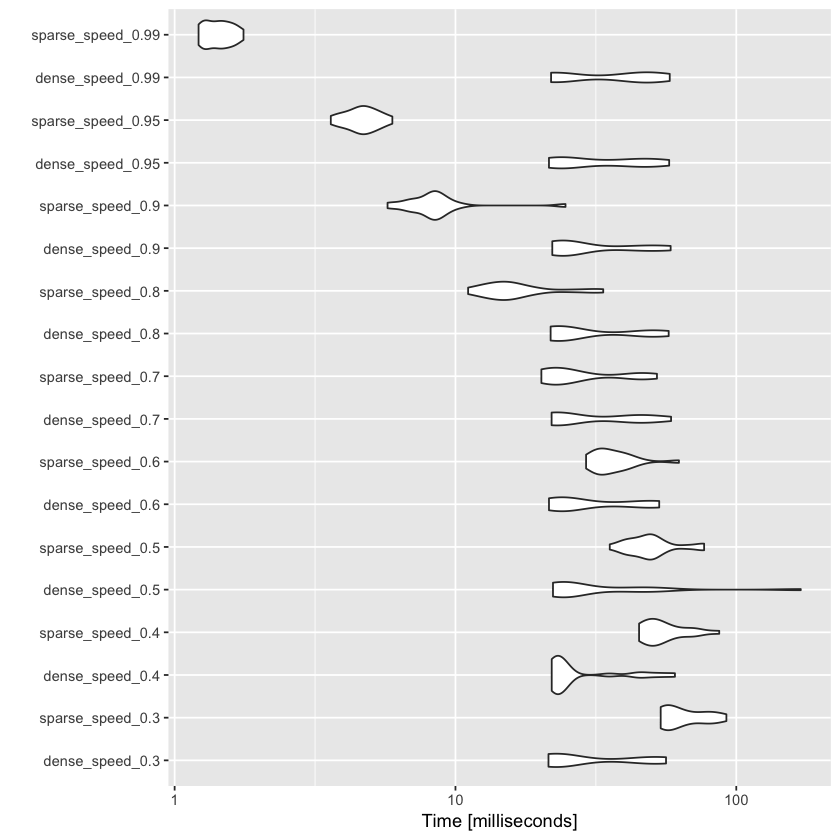

In [42]:
autoplot(single_effect_regression_speed_sparse)

In [34]:
#code from susie
single_effect_regression_cros = function(Y,X,sa2=1,s2=1,optimize_sa2=FALSE){
  d = colSums(X^2)
  V = s2*sa2 # scale by residual variance
  betahat = as.matrix((1/d) * crossprod(X, Y))   ### Add as.matrix() and change to crossprod()
  shat2 = s2/d
  if(optimize_sa2){
    if(loglik.grad(0,Y,X,s2)<0){
      V=0
    } else {
      V.u=uniroot(negloglik.grad.logscale,c(-10,10),extendInt = "upX",Y=Y,X=X,s2=s2)
      V = exp(V.u$root)
    }
  }
  lbf = dnorm(betahat,0,sqrt(V+shat2),log=TRUE) - dnorm(betahat,0,sqrt(shat2),log=TRUE)
  #log(bf) on each SNP
  
  maxlbf = max(lbf)
  w = exp(lbf-maxlbf) # w is proportional to BF, but subtract max for numerical stability
  alpha = w/sum(w) # posterior prob on each SNP
  
  post_var = (1/V + d/s2)^(-1) # posterior variance
  post_mean = (d/s2) * post_var * betahat
  post_mean2 = post_var + post_mean^2 # second moment
  loglik = maxlbf + log(mean(w)) + sum(dnorm(Y,0,sqrt(s2),log=TRUE))
  return(list(alpha=alpha,mu=post_mean,mu2 = post_mean2,lbf=lbf,sa2=V/s2, loglik = loglik))
}

loglik.grad = function(V,Y,X,s2){
  d = colSums(X^2)
  betahat = as.matrix((1/d) * crossprod(X,Y)) ### Add as.matrix() and change to crossprod()
  shat2 = s2/d
  
  lbf = dnorm(betahat,0,sqrt(V+shat2),log=TRUE) - dnorm(betahat,0,sqrt(shat2),log=TRUE)
  #log(bf) on each SNP
  
  maxlbf = max(lbf)
  w = exp(lbf-maxlbf) # w =BF/BFmax
  alpha = w/sum(w)
  sum(alpha*lbf.grad(V,shat2,betahat^2/shat2))
}

negloglik.logscale = function(lV, Y,X,s2){-loglik(exp(lV),Y,X,s2)}
negloglik.grad.logscale = function(lV,Y,X,s2){-exp(lV)*loglik.grad(exp(lV),Y,X,s2)}

lbf.grad = function(V,shat2,T2){
  0.5* (1/(V+shat2)) * ((shat2/(V+shat2))*T2-1)
}

lbf = function(V,shat2,T2){
  0.5*log(shat2/(V+shat2)) + 0.5*T2*(V/(V+shat2))
}

In [39]:
single_effect_regression_speed_with_cros = microbenchmark(
    sparse_speed_0.3_cros = single_effect_regression_cros(Y, X_sparse_list[[1]]),
    sparse_speed_0.3_regular = single_effect_regression(Y, X_sparse_list[[1]]),
    
    sparse_speed_0.4_cros = single_effect_regression_cros(Y, X_sparse_list[[2]]),
    sparse_speed_0.4_regular = single_effect_regression(Y, X_sparse_list[[2]]),
    
    sparse_speed_0.5_cros = single_effect_regression_cros(Y, X_sparse_list[[3]]),
    sparse_speed_0.5_regular = single_effect_regression(Y, X_sparse_list[[3]]),
    
    sparse_speed_0.6_cros = single_effect_regression_cros(Y, X_sparse_list[[4]]),
    sparse_speed_0.6_regular = single_effect_regression(Y, X_sparse_list[[4]]),
    
    sparse_speed_0.7_cros = single_effect_regression_cros(Y, X_sparse_list[[5]]),
    sparse_speed_0.7_regular = single_effect_regression(Y, X_sparse_list[[5]]),
    
    sparse_speed_0.8_cros = single_effect_regression_cros(Y, X_sparse_list[[6]]),
    sparse_speed_0.8_regular = single_effect_regression(Y, X_sparse_list[[6]]),
    
    sparse_speed_0.9_cros = single_effect_regression_cros(Y, X_sparse_list[[7]]),
    sparse_speed_0.9_regular = single_effect_regression(Y, X_sparse_list[[7]]),
    
    sparse_speed_0.95_cros = single_effect_regression_cros(Y, X_sparse_0.95),
    sparse_speed_0.95_regular = single_effect_regression(Y, X_sparse_0.95),
    
    sparse_speed_0.99_cros = single_effect_regression_cros(Y, X_sparse_0.99),
    sparse_speed_0.99_regular = single_effect_regression(Y, X_sparse_0.99),
    
    times=20)

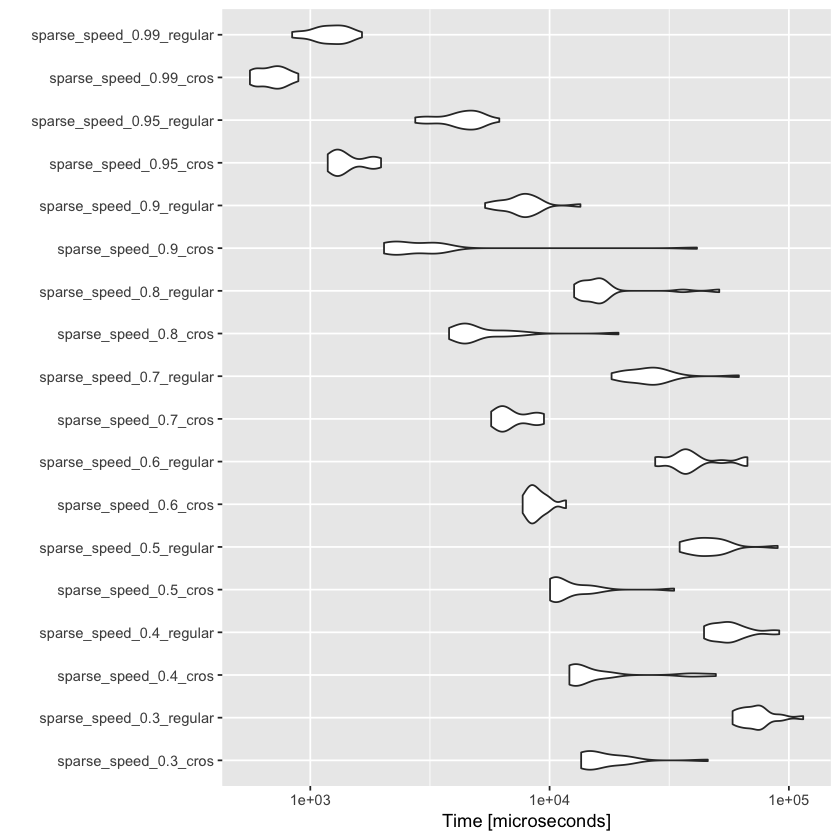

In [40]:
autoplot(single_effect_regression_speed_with_cros)

In [43]:
single_effect_regression_speed_all = microbenchmark(
    dense_speed_0.3_regular = single_effect_regression(Y, X_list[[1]]),
    sparse_speed_0.3_regular = single_effect_regression(Y, X_sparse_list[[1]]),
    sparse_speed_0.3_cros = single_effect_regression_cros(Y, X_sparse_list[[1]]),
    
    dense_speed_0.4_regular = single_effect_regression(Y, X_list[[2]]),
    sparse_speed_0.4_regular = single_effect_regression(Y, X_sparse_list[[2]]),
    sparse_speed_0.4_cros = single_effect_regression_cros(Y, X_sparse_list[[2]]),
    
    dense_speed_0.5_regular = single_effect_regression(Y, X_list[[3]]),
    sparse_speed_0.5_regular = single_effect_regression(Y, X_sparse_list[[3]]),
    sparse_speed_0.5_cros = single_effect_regression_cros(Y, X_sparse_list[[3]]),
    
    dense_speed_0.6_regular = single_effect_regression(Y, X_list[[4]]),
    sparse_speed_0.6_regular = single_effect_regression(Y, X_sparse_list[[4]]),
    sparse_speed_0.6_cros = single_effect_regression_cros(Y, X_sparse_list[[4]]),
    
    dense_speed_0.7_regular = single_effect_regression(Y, X_list[[5]]),
    sparse_speed_0.7_regular = single_effect_regression(Y, X_sparse_list[[5]]),
    sparse_speed_0.7_cros = single_effect_regression_cros(Y, X_sparse_list[[5]]),
    
    dense_speed_0.8_regular = single_effect_regression(Y, X_list[[6]]),
    sparse_speed_0.8_regular = single_effect_regression(Y, X_sparse_list[[6]]),
    sparse_speed_0.8_cros = single_effect_regression_cros(Y, X_sparse_list[[6]]),
    
    dense_speed_0.9_regular = single_effect_regression(Y, X_list[[7]]),
    sparse_speed_0.9_regular = single_effect_regression(Y, X_sparse_list[[7]]),
    sparse_speed_0.9_cros = single_effect_regression_cros(Y, X_sparse_list[[7]]),
    
    dense_speed_0.95_regular = single_effect_regression(Y, X_0.95),
    sparse_speed_0.95_regular = single_effect_regression(Y, X_sparse_0.95),
    sparse_speed_0.95_cros = single_effect_regression_cros(Y, X_sparse_0.95),
    
    dense_speed_0.99_regular = single_effect_regression(Y, X_0.99),
    sparse_speed_0.99_regular = single_effect_regression(Y, X_sparse_0.99),
    sparse_speed_0.99_cros = single_effect_regression_cros(Y, X_sparse_0.99),
    
    times=20)

Assume that X is a centered but not scaled 3000 by 1000 matrix with different levels of sparsity. Y is a length 3000 binary vector. For each sparsity level, I compare three methods: 

(1) dense matrix multiplication with %*% 

(2) sparse matrix multiplication with %*% 

(3) sparse matrix multiplication with crossprod()


notation A_speed_B_C means: 

* A(sparse/dense): matrix X in the form of ''dgCMatrix' or 'Matrix', i.e using sparse matrix multiplication or not

* B(0.3-0.99): sparsity of X

* C(cros/regular): using the function tcrossprod() or the default multiplication %*%


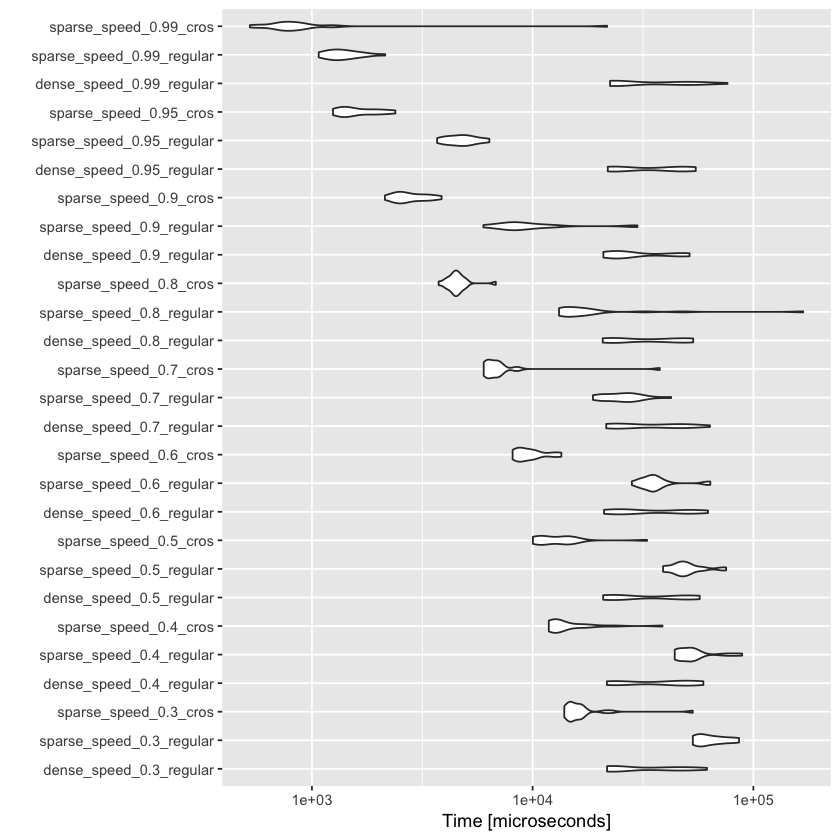

In [44]:
autoplot(single_effect_regression_speed_all)

This is a benchmark comparision for function *singe_effect_regression()*. Clearly, sparse multiplication with crossprod() has shorter time not only for matrices that are 0.7 or more, but also for matrices that have lower sparsity in this case.

### 2. update_each_effect

In [61]:
L=10
p=1000
n=3000
residual_variance=1
prior_variance=0.2
s = list(alpha=matrix(1/p,nrow=L,ncol=p), mu=matrix(0,nrow=L,ncol=p),
           mu2 = matrix(0,nrow=L,ncol=p), Xr=rep(0,n), sigma2= residual_variance, sa2= prior_variance, KL = rep(NA,L))

In [62]:
SER_posterior_e_loglik = function(X,Y,s2,Eb,Eb2){
  n = nrow(X)
  -0.5*n*log(2*pi*s2)  - (0.5/s2) * (sum(Y*Y) - 2*sum(Y*(X %*% Eb)) + sum(t(X^2)*as.vector(Eb2)))
}

In [69]:
update_each_effect <- function (X, Y, s_init=s, estimate_prior_variance=FALSE) {

  # Repeat for each effect to update
  s = s_init
  L = nrow(s$alpha)

  if(L>0){
    for (l in 1:L){
    # remove lth effect from fitted values
      s$Xr = s$Xr - as.matrix(X %*% (s$alpha[l,] * s$mu[l,])) ### Add as.matrix here

    #compute residuals
      R = Y - s$Xr
      res = single_effect_regression(R,X,s$sa2[l],s$sigma2,estimate_prior_variance)

    # Update the variational estimate of the posterior mean.
      s$mu[l,] <- res$mu
      s$alpha[l,] <- res$alpha
      s$mu2[l,] <- res$mu2
      s$sa2[l] <- res$sa2
      s$KL[l] <- -res$loglik + SER_posterior_e_loglik(X,R,s$sigma2,res$alpha*res$mu,res$alpha*res$mu2)

      s$Xr <- s$Xr + as.matrix(X %*% (s$alpha[l,]*s$mu[l,]))   ### Add as.matrix here
    }
  }

  return(s)
}

In [71]:
update_each_effect_speed_sparse = microbenchmark(
    dense_speed_0.3 = update_each_effect(X_list[[1]], Y),
    sparse_speed_0.3 = update_each_effect(X_sparse_list[[1]], Y),
    
    dense_speed_0.4 = update_each_effect(X_list[[2]], Y),
    sparse_speed_0.4 = update_each_effect(X_sparse_list[[2]], Y),
    
    dense_speed_0.5 = update_each_effect(X_list[[3]], Y),
    sparse_speed_0.5 = update_each_effect(X_sparse_list[[3]], Y),
    
    dense_speed_0.6 = update_each_effect(X_list[[4]], Y),
    sparse_speed_0.6 = update_each_effect(X_sparse_list[[4]], Y),
    
    dense_speed_0.7 = update_each_effect(X_list[[5]], Y),
    sparse_speed_0.7 = update_each_effect(X_sparse_list[[5]], Y),
    
    dense_speed_0.8 = update_each_effect(X_list[[6]], Y),
    sparse_speed_0.8 = update_each_effect(X_sparse_list[[6]], Y),
    
    dense_speed_0.9 = update_each_effect(X_list[[7]], Y),
    sparse_speed_0.9 = update_each_effect(X_sparse_list[[7]], Y),
    
    dense_speed_0.95 = update_each_effect(X_0.95, Y),
    sparse_speed_0.95 = update_each_effect(X_sparse_0.95, Y),
    
    dense_speed_0.99 = update_each_effect(X_0.99, Y),
    sparse_speed_0.99 = update_each_effect(X_sparse_0.99, Y),
    
    times=5)

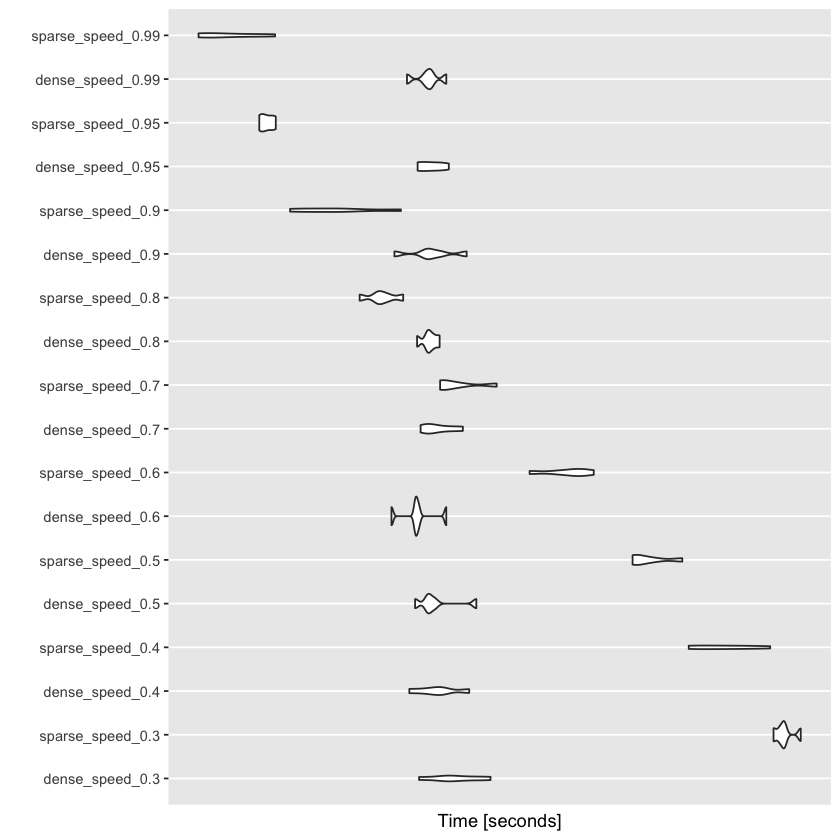

In [72]:
autoplot(update_each_effect_speed_sparse)

In [73]:
SER_posterior_e_loglik_cros = function(X,Y,s2,Eb,Eb2){
  n = nrow(X)
  -0.5*n*log(2*pi*s2)  - (0.5/s2) * (sum(Y*Y) - 2*sum(Y*tcrossprod(X, t(Eb))) + sum(t(X^2)*as.vector(Eb2)))
}  ### Change to tcrossprod() here

In [74]:
update_each_effect_cros <- function (X, Y, s_init=s, estimate_prior_variance=FALSE) {

  # Repeat for each effect to update
  s = s_init
  L = nrow(s$alpha)

  if(L>0){
    for (l in 1:L){
    # remove lth effect from fitted values
      s$Xr = s$Xr - as.matrix(tcrossprod(X, t(s$alpha[l,] * s$mu[l,]))) ### Add as.matrix here and change to tcrossprod()

    #compute residuals
      R = Y - s$Xr
      res = single_effect_regression_cros(R,X,s$sa2[l],s$sigma2,estimate_prior_variance)

    # Update the variational estimate of the posterior mean.
      s$mu[l,] <- res$mu
      s$alpha[l,] <- res$alpha
      s$mu2[l,] <- res$mu2
      s$sa2[l] <- res$sa2
      s$KL[l] <- -res$loglik + SER_posterior_e_loglik_cros(X,R,s$sigma2,res$alpha*res$mu,res$alpha*res$mu2)

      s$Xr <- s$Xr + as.matrix(tcrossprod(X, t(s$alpha[l,]*s$mu[l,])))   ### Add as.matrix here and change to tcrossprod()
    }
  }

  return(s)
}

In [75]:
update_each_effect_speed_cros = microbenchmark(
    sparse_speed_0.3_regular = update_each_effect(X_sparse_list[[1]], Y),
    sparse_speed_0.3_cros = update_each_effect_cros(X_sparse_list[[1]], Y),
    
    sparse_speed_0.4_regular = update_each_effect(X_sparse_list[[2]], Y),
    sparse_speed_0.4_cros = update_each_effect_cros(X_sparse_list[[2]], Y),
    
    sparse_speed_0.5_regular = update_each_effect(X_sparse_list[[3]], Y),
    sparse_speed_0.5_cros = update_each_effect_cros(X_sparse_list[[3]], Y),
    
    sparse_speed_0.6_regular = update_each_effect(X_sparse_list[[4]], Y),
    sparse_speed_0.6_cros = update_each_effect_cros(X_sparse_list[[4]], Y),
    
    sparse_speed_0.7_regular = update_each_effect(X_sparse_list[[5]], Y),
    sparse_speed_0.7_cros = update_each_effect_cros(X_sparse_list[[5]], Y),
    
    sparse_speed_0.8_regular = update_each_effect(X_sparse_list[[6]], Y),
    sparse_speed_0.8_cros = update_each_effect_cros(X_sparse_list[[6]], Y),
    
    sparse_speed_0.9_regular = update_each_effect(X_sparse_list[[7]], Y),
    sparse_speed_0.9_cros = update_each_effect_cros(X_sparse_list[[7]], Y),
    
    sparse_speed_0.95_regular = update_each_effect(X_sparse_0.95, Y),
    sparse_speed_0.95_cros = update_each_effect_cros(X_sparse_0.95, Y),
    
    sparse_speed_0.99_regular = update_each_effect(X_sparse_0.99, Y),
    sparse_speed_0.99_cros = update_each_effect_cros(X_sparse_0.99, Y),
    
    times=5)

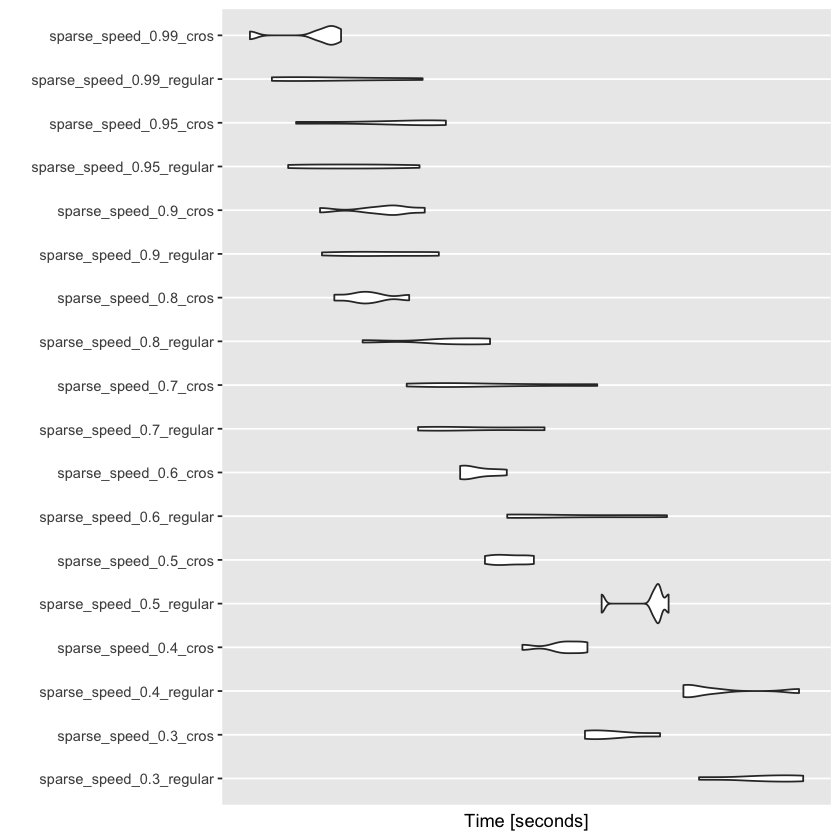

In [76]:
autoplot(update_each_effect_speed_cros)

cross sparse not really has great advantage over regular sparse.

In [77]:
update_each_effect_speed_all = microbenchmark(
    dense_speed_0.3_regular = update_each_effect(X_list[[1]], Y),
    sparse_speed_0.3_regular = update_each_effect(X_sparse_list[[1]], Y),
    sparse_speed_0.3_cros = update_each_effect_cros(X_sparse_list[[1]], Y),
    
    dense_speed_0.4_regular = update_each_effect(X_list[[2]], Y),
    sparse_speed_0.4_regular = update_each_effect(X_sparse_list[[2]], Y),
    sparse_speed_0.4_cros = update_each_effect_cros(X_sparse_list[[2]], Y),
    
    dense_speed_0.5_regular = update_each_effect(X_list[[3]], Y),
    sparse_speed_0.5_regular = update_each_effect(X_sparse_list[[3]], Y),
    sparse_speed_0.5_cros = update_each_effect_cros(X_sparse_list[[3]], Y),
    
    dense_speed_0.6_regular = update_each_effect(X_list[[4]], Y),
    sparse_speed_0.6_regular = update_each_effect(X_sparse_list[[4]], Y),
    sparse_speed_0.6_cros = update_each_effect_cros(X_sparse_list[[4]], Y),
    
    dense_speed_0.7_regular = update_each_effect(X_list[[5]], Y),
    sparse_speed_0.7_regular = update_each_effect(X_sparse_list[[5]], Y),
    sparse_speed_0.7_cros = update_each_effect_cros(X_sparse_list[[5]], Y),
    
    dense_speed_0.8_regular = update_each_effect(X_list[[6]], Y),
    sparse_speed_0.8_regular = update_each_effect(X_sparse_list[[6]], Y),
    sparse_speed_0.8_cros = update_each_effect_cros(X_sparse_list[[6]], Y),
    
    dense_speed_0.9_regular = update_each_effect(X_list[[7]], Y),
    sparse_speed_0.9_regular = update_each_effect(X_sparse_list[[7]], Y),
    sparse_speed_0.9_cros = update_each_effect_cros(X_sparse_list[[7]], Y),
    
    dense_speed_0.95_regular = update_each_effect(X_0.95, Y),
    sparse_speed_0.95_regular = update_each_effect(X_sparse_0.95, Y),
    sparse_speed_0.95_cros = update_each_effect_cros(X_sparse_0.95, Y),
    
    dense_speed_0.99_regular = update_each_effect(X_0.99, Y),
    sparse_speed_0.99_regular = update_each_effect(X_sparse_0.99, Y),
    sparse_speed_0.99_cros = update_each_effect_cros(X_sparse_0.99, Y),
    
    times=5)

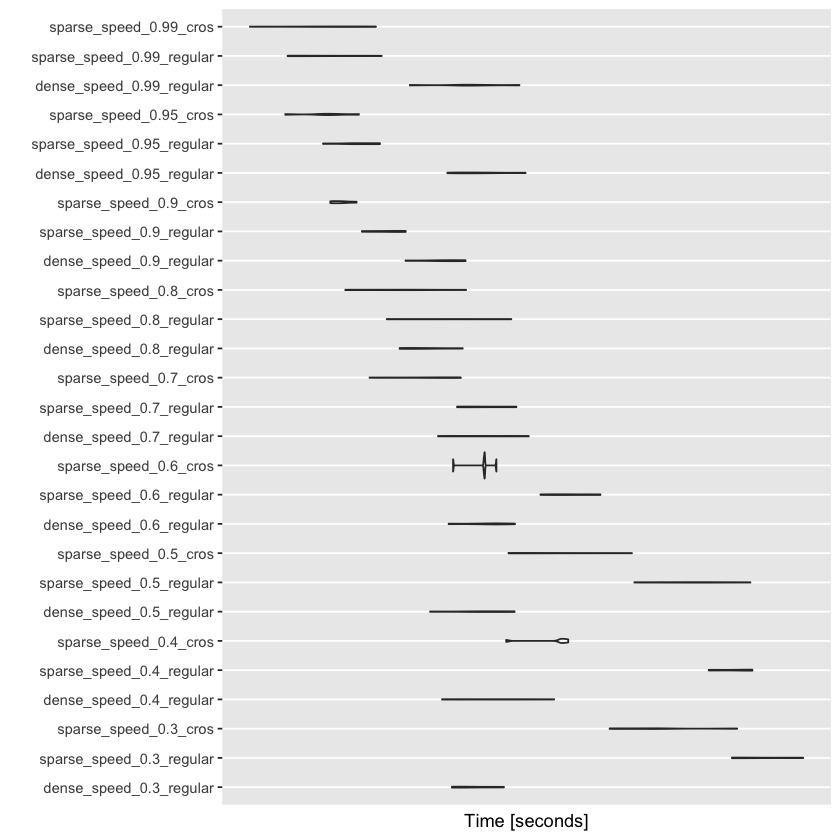

In [78]:
autoplot(update_each_effect_speed_all)

This is a benchmark comparsion for the function update_each_effect(). Sparse matrix multiplication has advantage when the sparsity is at or above 0.7. In this case, tcrossprod() is not that much better than %*%. 

### 3. get_ER2() in estimate_residual_variance() and susie_get_objective()

In [88]:
get_ER2 = function(X,Y,s){
  Xr = (s$alpha*s$mu) %*% t(X)
  Xrsum = colSums(Xr)

  d = colSums(X*X)
  postb2 = s$alpha * s$mu2 #posterior second moment

  return(sum((Y-Xrsum)^2) - sum(Xr^2) + sum(d*t(postb2)))
}

In [90]:
get_ER2_speed_sparse = microbenchmark(
    dense_speed_0.3 = get_ER2(X_list[[1]], Y, s),
    sparse_speed_0.3 = get_ER2(X_sparse_list[[1]], Y, s),
    
    dense_speed_0.4 = get_ER2(X_list[[2]], Y, s),
    sparse_speed_0.4 = get_ER2(X_sparse_list[[2]], Y, s),
    
    dense_speed_0.5 = get_ER2(X_list[[3]], Y, s),
    sparse_speed_0.5 = get_ER2(X_sparse_list[[3]], Y, s),
    
    dense_speed_0.6 = get_ER2(X_list[[4]], Y, s),
    sparse_speed_0.6 = get_ER2(X_sparse_list[[4]], Y, s),
    
    dense_speed_0.7 = get_ER2(X_list[[5]], Y, s),
    sparse_speed_0.7 = get_ER2(X_sparse_list[[5]], Y, s),
    
    dense_speed_0.8 = get_ER2(X_list[[6]], Y, s),
    sparse_speed_0.8 = get_ER2(X_sparse_list[[6]], Y, s),
    
    dense_speed_0.9 = get_ER2(X_list[[7]], Y, s),
    sparse_speed_0.9 = get_ER2(X_sparse_list[[7]], Y, s),
    
    dense_speed_0.95 = get_ER2(X_0.95, Y, s),
    sparse_speed_0.95 = get_ER2(X_sparse_0.95, Y, s),
    
    dense_speed_0.99 = get_ER2(X_0.99, Y, s),
    sparse_speed_0.99 = get_ER2(X_sparse_0.99, Y, s),
    
    times=5)

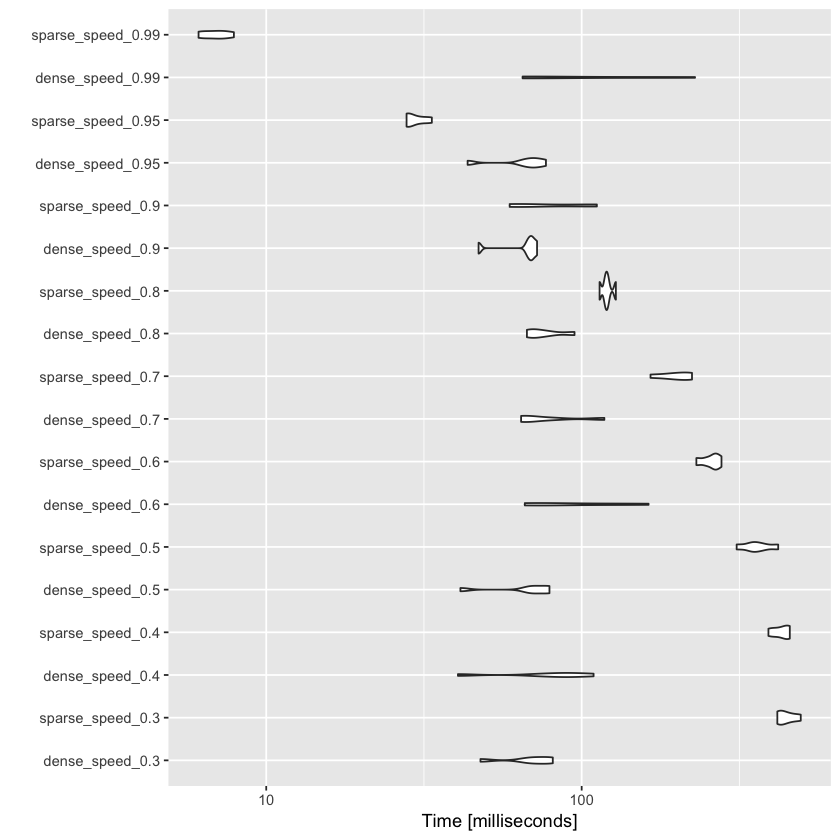

In [91]:
autoplot(get_ER2_speed_sparse)

In [93]:
get_ER2_cros = function(X,Y,s){
  Xr = tcrossprod((s$alpha*s$mu), X)
  Xrsum = colSums(Xr)

  d = colSums(X*X)
  postb2 = s$alpha * s$mu2 #posterior second moment

  return(sum((Y-Xrsum)^2) - sum(Xr^2) + sum(d*t(postb2)))
}

In [94]:
get_ER2_speed_cros = microbenchmark(
    sparse_speed_0.3_regular = get_ER2(X_sparse_list[[1]], Y, s),
    sparse_speed_0.3_cros = get_ER2_cros(X_sparse_list[[1]], Y, s),
    
    sparse_speed_0.4_regular = get_ER2(X_sparse_list[[2]], Y, s),
    sparse_speed_0.4_cros = get_ER2_cros(X_sparse_list[[2]], Y, s),
    
    sparse_speed_0.5_regular = get_ER2(X_sparse_list[[3]], Y, s),
    sparse_speed_0.5_cros = get_ER2_cros(X_sparse_list[[3]], Y, s),
    
    sparse_speed_0.6_regular = get_ER2(X_sparse_list[[4]], Y, s),
    sparse_speed_0.6_cros = get_ER2_cros(X_sparse_list[[4]], Y, s),
    
    sparse_speed_0.7_regular = get_ER2(X_sparse_list[[5]], Y, s),
    sparse_speed_0.7_cros = get_ER2_cros(X_sparse_list[[5]], Y, s),
    
    sparse_speed_0.8_regular = get_ER2(X_sparse_list[[6]], Y, s),
    sparse_speed_0.8_cros = get_ER2_cros(X_sparse_list[[6]], Y, s),
    
    sparse_speed_0.9_regular = get_ER2(X_sparse_list[[7]], Y, s),
    sparse_speed_0.9_cros = get_ER2_cros(X_sparse_list[[7]], Y, s),
    
    sparse_speed_0.95_regular = get_ER2(X_sparse_0.95, Y, s),
    sparse_speed_0.95_cros = get_ER2_cros(X_sparse_0.95, Y, s),
    
    sparse_speed_0.99_regular = get_ER2(X_sparse_0.99, Y, s),
    sparse_speed_0.99_cros = get_ER2_cros(X_sparse_0.99, Y, s),
    
    times=5)

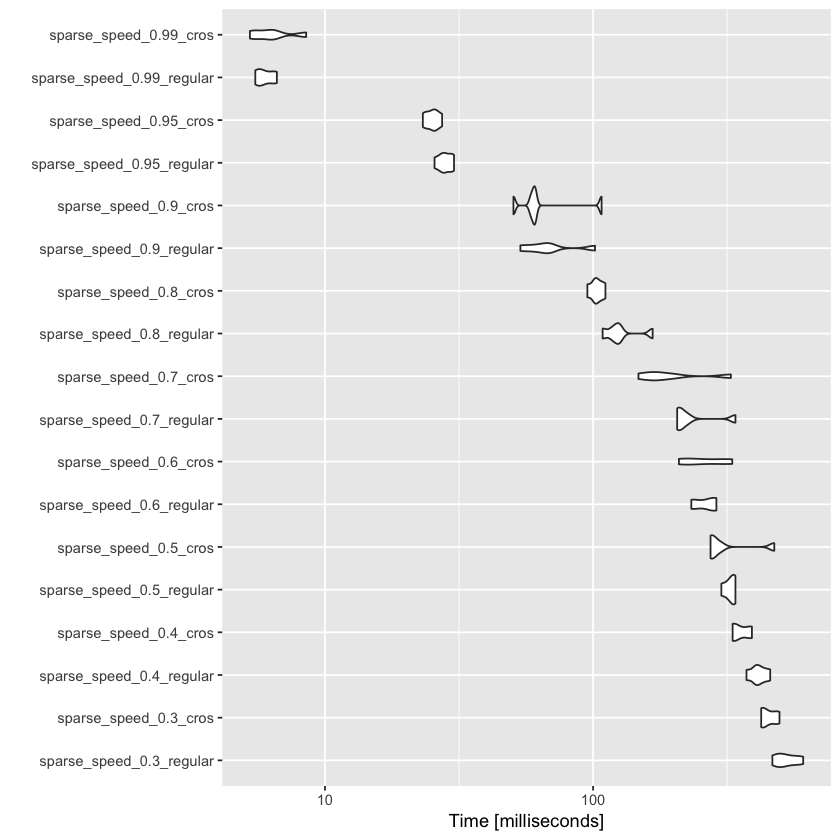

In [95]:
autoplot(get_ER2_speed_cros)

In [96]:
get_ER2_speed_all = microbenchmark(
    dense_speed_0.3_regular = get_ER2(X_list[[1]], Y, s),
    sparse_speed_0.3_regular = get_ER2(X_sparse_list[[1]], Y, s),
    sparse_speed_0.3_cros = get_ER2_cros(X_sparse_list[[1]], Y, s),
    
    dense_speed_0.4_regular = get_ER2(X_list[[2]], Y, s),
    sparse_speed_0.4_regular = get_ER2(X_sparse_list[[2]], Y, s),
    sparse_speed_0.4_cros = get_ER2_cros(X_sparse_list[[2]], Y, s),
    
    dense_speed_0.5_regular = get_ER2(X_list[[3]], Y, s),
    sparse_speed_0.5_regular = get_ER2(X_sparse_list[[3]], Y, s),
    sparse_speed_0.5_cros = get_ER2_cros(X_sparse_list[[3]], Y, s),
    
    dense_speed_0.6_regular = get_ER2(X_list[[4]], Y, s),
    sparse_speed_0.6_regular = get_ER2(X_sparse_list[[4]], Y, s),
    sparse_speed_0.6_cros = get_ER2_cros(X_sparse_list[[4]], Y, s),
    
    dense_speed_0.7_regular = get_ER2(X_list[[5]], Y, s),
    sparse_speed_0.7_regular = get_ER2(X_sparse_list[[5]], Y, s),
    sparse_speed_0.7_cros = get_ER2_cros(X_sparse_list[[5]], Y, s),
    
    dense_speed_0.8_regular = get_ER2(X_list[[6]], Y, s),
    sparse_speed_0.8_regular = get_ER2(X_sparse_list[[6]], Y, s),
    sparse_speed_0.8_cros = get_ER2_cros(X_sparse_list[[6]], Y, s),
    
    dense_speed_0.9_regular = get_ER2(X_list[[7]], Y, s),
    sparse_speed_0.9_regular = get_ER2(X_sparse_list[[7]], Y, s),
    sparse_speed_0.9_cros = get_ER2_cros(X_sparse_list[[7]], Y, s),
    
    dense_speed_0.95_regular = get_ER2(X_0.95, Y, s),
    sparse_speed_0.95_regular = get_ER2(X_sparse_0.95, Y, s),
    sparse_speed_0.95_cros = get_ER2_cros(X_sparse_0.95, Y, s),
    
    dense_speed_0.99_regular = get_ER2(X_0.99, Y, s),
    sparse_speed_0.99_regular = get_ER2(X_sparse_0.99, Y, s),
    sparse_speed_0.99_cros = get_ER2_cros(X_sparse_0.99, Y, s),
    
    times=5)

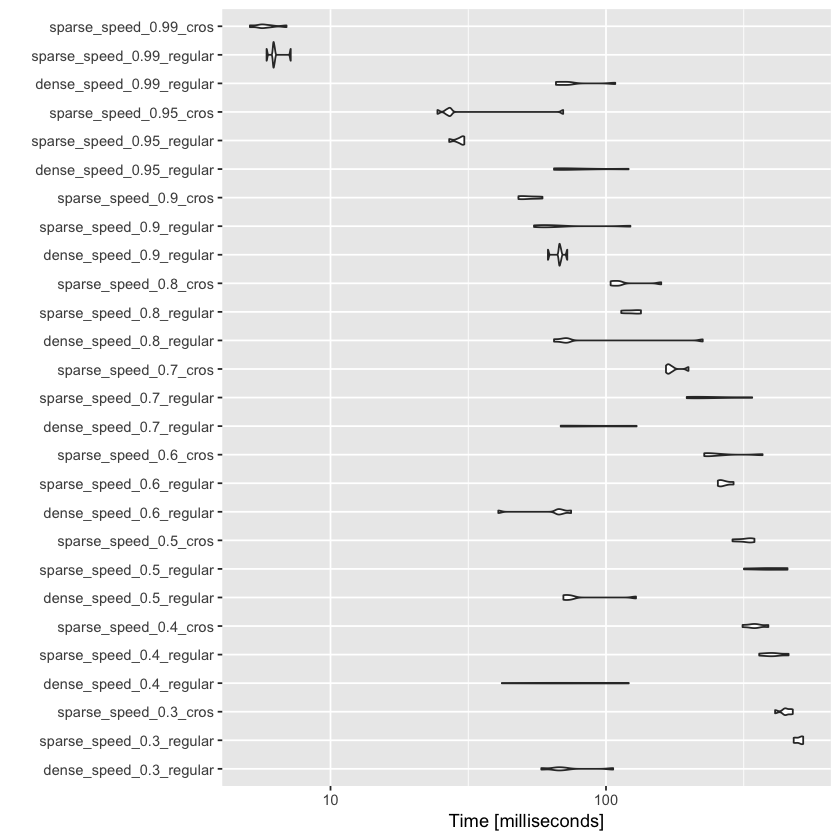

In [97]:
autoplot(get_ER2_speed_all)

This is a benchmark comparison for the function get_ER2(). Only when sparsity>0.9, sparse has a obvious advantage over dense matrix. 

### 3. susieR

In [98]:
Eloglik = function(X,Y,s){
  n = nrow(X)
  p = ncol(X)
  result =  -(n/2) * log(2*pi* s$sigma2) - (1/(2*s$sigma2)) * get_ER2(X,Y,s)
  return(result)
}

In [99]:
susie_get_objective = function(X, Y, s) {
  return(Eloglik(X,Y,s)-sum(s$KL))
}

#' @title expected loglikelihood for a susie fit
Eloglik = function(X,Y,s){
  n = nrow(X)
  p = ncol(X)
  result =  -(n/2) * log(2*pi* s$sigma2) - (1/(2*s$sigma2)) * get_ER2(X,Y,s)
  return(result)
}

In [100]:
estimate_residual_variance = function(X,Y, s){
  n = nrow(X)
  return( (1/n)* get_ER2(X,Y,s) )
}

In [106]:
susie = function(X,Y,L=10,prior_variance=0.2,residual_variance=NULL,standardize=TRUE,intercept=TRUE,max_iter=100,tol=1e-2,estimate_residual_variance=TRUE,estimate_prior_variance = FALSE, s_init = NULL, verbose=FALSE){
  # Check input X.
  #if (!is.double(X) || !is.matrix(X))
    #stop("Input X must be a double-precision matrix")  ### Delete check here
  p = ncol(X)
  n = nrow(X)
  mean_y = mean(Y)

  if(intercept){ # center Y and X
    Y = Y-mean_y
    #X = scale(X,center=TRUE, scale = FALSE)    ### Delete two scales
  } else {
    attr(X,"scaled:center")=rep(0,p)
  }

  #if(standardize){
  #  X = scale(X,center=FALSE, scale=TRUE)
  #} else {
  #  attr(X,"scaled:scale")=rep(1,p)
  #}

  # initialize susie fit
  if(!is.null(s_init)){
    if(!missing(L) || !missing(prior_variance) || !missing(residual_variance))
      stop("if provide s_init then L, sa2 and sigma2 must not be provided")
    s = s_init
  } else {

    if(is.null(residual_variance)){
      residual_variance=var(Y)
    }
    residual_variance= as.numeric(residual_variance) #avoid problems with dimension if entered as matrix


    if(length(prior_variance)==1){
      prior_variance = rep(prior_variance,L)
    }

    # Check inputs sigma and sa.
    if (length(residual_variance) != 1)
      stop("Inputs residual_variance must be scalar")
    # Check inputs sigma and sa.
    if (length(prior_variance) != L)
      stop("Inputs prior_variance must be of length 1 or L")

  #initialize susie fit
   s = list(alpha=matrix(1/p,nrow=L,ncol=p), mu=matrix(0,nrow=L,ncol=p),
           mu2 = matrix(0,nrow=L,ncol=p), Xr=rep(0,n), sigma2= residual_variance, sa2= prior_variance, KL = rep(NA,L))
    class(s) <- "susie"
  }

  #intialize elbo to NA
  elbo = rep(NA,max_iter+1)
  elbo[1] = -Inf;

  for(i in 1:max_iter){
    #s = add_null_effect(s,0)
    s = update_each_effect(X, Y, s, estimate_prior_variance)
    if(verbose){
        print(paste0("objective:",susie_get_objective(X,Y,s)))
    }
    if(estimate_residual_variance){
      new_sigma2 = estimate_residual_variance(X,Y,s)
      s$sa2 = (s$sa2*s$sigma2)/new_sigma2 # this is so prior variance does not change with update
      s$sigma2 = new_sigma2
      if(verbose){
        print(paste0("objective:",susie_get_objective(X,Y,s)))
      }
    }
    #s = remove_null_effects(s)

    elbo[i+1] = susie_get_objective(X,Y,s)
    if((elbo[i+1]-elbo[i])<tol) break;
  }
  elbo = elbo[1:(i+1)] #remove trailing NAs
  s$elbo <- elbo
  s$niter <- i

  if(intercept){
    s$intercept = mean_y - sum(attr(X,"scaled:center")* (colSums(s$alpha*s$mu)/attr(X,"scaled:scale")))# estimate intercept (unshrunk)
    s$fitted = s$Xr + mean_y
  } else {
    s$intercept = 0
    s$fitted = s$Xr
  }

  s$X_column_scale_factors = attr(X,"scaled:scale")

  return(s)
}

In [110]:
susie_speed_sparse = microbenchmark(
    dense_speed_0.3 = susie(X_list[[1]], Y),
    sparse_speed_0.3 = susie(X_sparse_list[[1]], Y),
    
    dense_speed_0.4 = susie(X_list[[2]], Y),
    sparse_speed_0.4 = susie(X_sparse_list[[2]], Y),
    
    dense_speed_0.5 = susie(X_list[[3]], Y),
    sparse_speed_0.5 = susie(X_sparse_list[[3]], Y),
    
    dense_speed_0.6 = susie(X_list[[4]], Y),
    sparse_speed_0.6 = susie(X_sparse_list[[4]], Y),
    
    dense_speed_0.7 = susie(X_list[[5]], Y),
    sparse_speed_0.7 = susie(X_sparse_list[[5]], Y),
    
    dense_speed_0.8 = susie(X_list[[6]], Y),
    sparse_speed_0.8 = susie(X_sparse_list[[6]], Y),
    
    dense_speed_0.9 = susie(X_list[[7]], Y),
    sparse_speed_0.9 = susie(X_sparse_list[[7]], Y),
    
    dense_speed_0.95 = susie(X_0.95, Y),
    sparse_speed_0.95 = susie(X_sparse_0.95, Y),
    
    dense_speed_0.99 = susie(X_0.99, Y),
    sparse_speed_0.99 = susie(X_sparse_0.99, Y),
    
    times=20)

I use browser() in the susie to monitor if X always dgCMtrix format when inputting dgCMatrix. It turns out if we take out two scale, X is always dgCMtrix format along the way. 

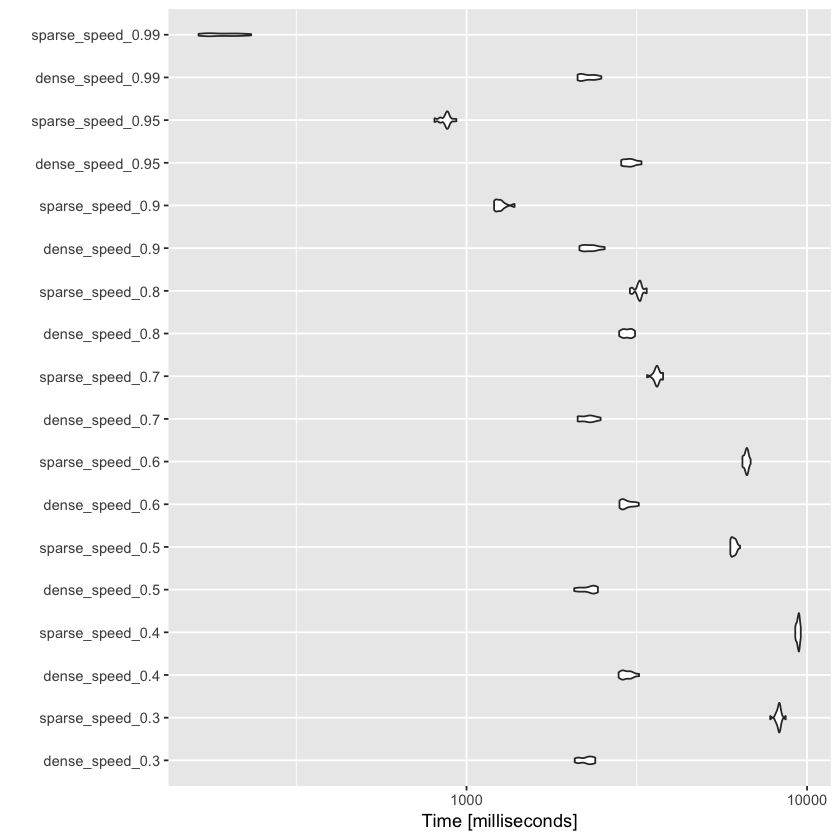

In [111]:
autoplot(susie_speed_sparse)

In [112]:
Eloglik_cros = function(X,Y,s){
  n = nrow(X)
  p = ncol(X)
  result =  -(n/2) * log(2*pi* s$sigma2) - (1/(2*s$sigma2)) * get_ER2_cros(X,Y,s)
  return(result)
}

In [113]:
susie_get_objective_cros = function(X, Y, s) {
  return(Eloglik_cros(X,Y,s)-sum(s$KL))
}

#' @title expected loglikelihood for a susie fit
Eloglik_cros = function(X,Y,s){
  n = nrow(X)
  p = ncol(X)
  result =  -(n/2) * log(2*pi* s$sigma2) - (1/(2*s$sigma2)) * get_ER2_cros(X,Y,s)
  return(result)
}

In [114]:
estimate_residual_variance_cros = function(X,Y, s){
  n = nrow(X)
  return( (1/n)* get_ER2_cros(X,Y,s) )
}

In [115]:
susie_cros = function(X,Y,L=10,prior_variance=0.2,residual_variance=NULL,standardize=TRUE,intercept=TRUE,max_iter=100,tol=1e-2,estimate_residual_variance=TRUE,estimate_prior_variance = FALSE, s_init = NULL, verbose=FALSE){
  # Check input X.
  #if (!is.double(X) || !is.matrix(X))
    #stop("Input X must be a double-precision matrix")  ### Delete check here
  p = ncol(X)
  n = nrow(X)
  mean_y = mean(Y)

  if(intercept){ # center Y and X
    Y = Y-mean_y
    #X = scale(X,center=TRUE, scale = FALSE)    ### Delete two scales
  } else {
    attr(X,"scaled:center")=rep(0,p)
  }

  #if(standardize){
  #  X = scale(X,center=FALSE, scale=TRUE)
  #} else {
  #  attr(X,"scaled:scale")=rep(1,p)
  #}

  # initialize susie fit
  if(!is.null(s_init)){
    if(!missing(L) || !missing(prior_variance) || !missing(residual_variance))
      stop("if provide s_init then L, sa2 and sigma2 must not be provided")
    s = s_init
  } else {

    if(is.null(residual_variance)){
      residual_variance=var(Y)
    }
    residual_variance= as.numeric(residual_variance) #avoid problems with dimension if entered as matrix


    if(length(prior_variance)==1){
      prior_variance = rep(prior_variance,L)
    }

    # Check inputs sigma and sa.
    if (length(residual_variance) != 1)
      stop("Inputs residual_variance must be scalar")
    # Check inputs sigma and sa.
    if (length(prior_variance) != L)
      stop("Inputs prior_variance must be of length 1 or L")

  #initialize susie fit
   s = list(alpha=matrix(1/p,nrow=L,ncol=p), mu=matrix(0,nrow=L,ncol=p),
           mu2 = matrix(0,nrow=L,ncol=p), Xr=rep(0,n), sigma2= residual_variance, sa2= prior_variance, KL = rep(NA,L))
    class(s) <- "susie"
  }

  #intialize elbo to NA
  elbo = rep(NA,max_iter+1)
  elbo[1] = -Inf;

  for(i in 1:max_iter){
    #s = add_null_effect(s,0)
    s = update_each_effect_cros(X, Y, s, estimate_prior_variance) ### change here
    if(verbose){
        print(paste0("objective:",susie_get_objective_cros(X,Y,s)))
    }
    if(estimate_residual_variance){
      new_sigma2 = estimate_residual_variance_cros(X,Y,s) ### change here 
      s$sa2 = (s$sa2*s$sigma2)/new_sigma2 # this is so prior variance does not change with update
      s$sigma2 = new_sigma2
      if(verbose){
        print(paste0("objective:",susie_get_objective_cros(X,Y,s))) ### change here 
      }
    }
    #s = remove_null_effects(s)

    elbo[i+1] = susie_get_objective_cros(X,Y,s) ### change here 
    if((elbo[i+1]-elbo[i])<tol) break;
  }
  elbo = elbo[1:(i+1)] #remove trailing NAs
  s$elbo <- elbo
  s$niter <- i

  if(intercept){
    s$intercept = mean_y - sum(attr(X,"scaled:center")* (colSums(s$alpha*s$mu)/attr(X,"scaled:scale")))# estimate intercept (unshrunk)
    s$fitted = s$Xr + mean_y
  } else {
    s$intercept = 0
    s$fitted = s$Xr
  }

  s$X_column_scale_factors = attr(X,"scaled:scale")

  return(s)
}

In [116]:
susie_speed_cros = microbenchmark(
    sparse_speed_0.3_regular = susie(X_sparse_list[[1]], Y),
    sparse_speed_0.3_cros = susie_cros(X_sparse_list[[1]], Y),
    
    sparse_speed_0.4_regular = susie(X_sparse_list[[2]], Y),
    sparse_speed_0.4_cros = susie_cros(X_sparse_list[[2]], Y),
    
    sparse_speed_0.5_regular = susie(X_sparse_list[[3]], Y),
    sparse_speed_0.5_cros = susie_cros(X_sparse_list[[3]], Y),
    
    sparse_speed_0.6_regular = susie(X_sparse_list[[4]], Y),
    sparse_speed_0.6_cros = susie_cros(X_sparse_list[[4]], Y),
    
    sparse_speed_0.7_regular = susie(X_sparse_list[[5]], Y),
    sparse_speed_0.7_cros = susie_cros(X_sparse_list[[5]], Y),
    
    sparse_speed_0.8_regular = susie(X_sparse_list[[6]], Y),
    sparse_speed_0.8_cros = susie_cros(X_sparse_list[[6]], Y),
    
    sparse_speed_0.9_regular = susie(X_sparse_list[[7]], Y),
    sparse_speed_0.9_cros = susie_cros(X_sparse_list[[7]], Y),
    
    sparse_speed_0.95_regular = susie(X_sparse_0.95, Y),
    sparse_speed_0.95_cros = susie_cros(X_sparse_0.95, Y),
    
    sparse_speed_0.99_regular = susie(X_sparse_0.99, Y),
    sparse_speed_0.99_cros = susie_cros(X_sparse_0.99, Y),
    
    times=5)

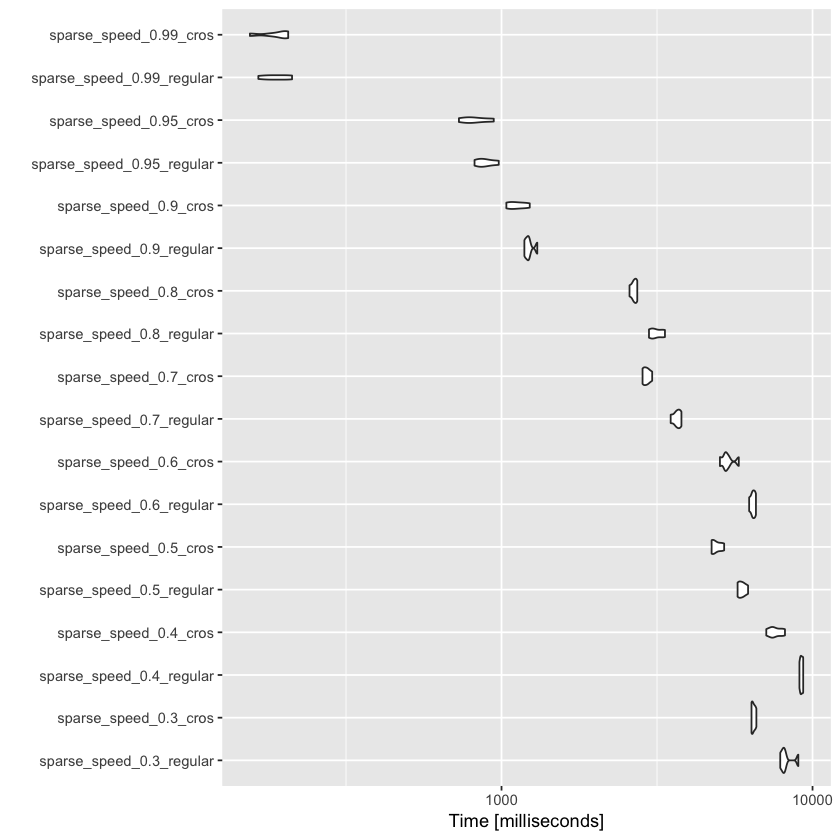

In [117]:
autoplot(susie_speed_cros)

In [118]:
susie_speed_all = microbenchmark(
    dense_speed_0.3_regular = susie(X_list[[1]], Y),
    sparse_speed_0.3_regular = susie(X_sparse_list[[1]], Y),
    sparse_speed_0.3_cros = susie_cros(X_sparse_list[[1]], Y),
    
    dense_speed_0.4_regular = susie(X_list[[2]], Y),
    sparse_speed_0.4_regular = susie(X_sparse_list[[2]], Y),
    sparse_speed_0.4_cros = susie_cros(X_sparse_list[[2]], Y),
    
    dense_speed_0.5_regular = susie(X_list[[3]], Y),
    sparse_speed_0.5_regular = susie(X_sparse_list[[3]], Y),
    sparse_speed_0.5_cros = susie_cros(X_sparse_list[[3]], Y),
    
    dense_speed_0.6_regular = susie(X_list[[4]], Y),
    sparse_speed_0.6_regular = susie(X_sparse_list[[4]], Y),
    sparse_speed_0.6_cros = susie_cros(X_sparse_list[[4]], Y),
    
    dense_speed_0.7_regular = susie(X_list[[5]], Y),
    sparse_speed_0.7_regular = susie(X_sparse_list[[5]], Y),
    sparse_speed_0.7_cros = susie_cros(X_sparse_list[[5]], Y),
    
    dense_speed_0.8_regular = susie(X_list[[6]], Y),
    sparse_speed_0.8_regular = susie(X_sparse_list[[6]], Y),
    sparse_speed_0.8_cros = susie_cros(X_sparse_list[[6]], Y),
    
    dense_speed_0.9_regular = susie(X_list[[7]], Y),
    sparse_speed_0.9_regular = susie(X_sparse_list[[7]], Y),
    sparse_speed_0.9_cros = susie_cros(X_sparse_list[[7]], Y),
    
    dense_speed_0.95_regular = susie(X_0.95, Y),
    sparse_speed_0.95_regular = susie(X_sparse_0.95, Y),
    sparse_speed_0.95_cros = susie_cros(X_sparse_0.95, Y),
    
    dense_speed_0.99_regular = susie(X_0.99, Y),
    sparse_speed_0.99_regular = susie(X_sparse_0.99, Y),
    sparse_speed_0.99_cros = susie_cros(X_sparse_0.99, Y),
    
    times=5)

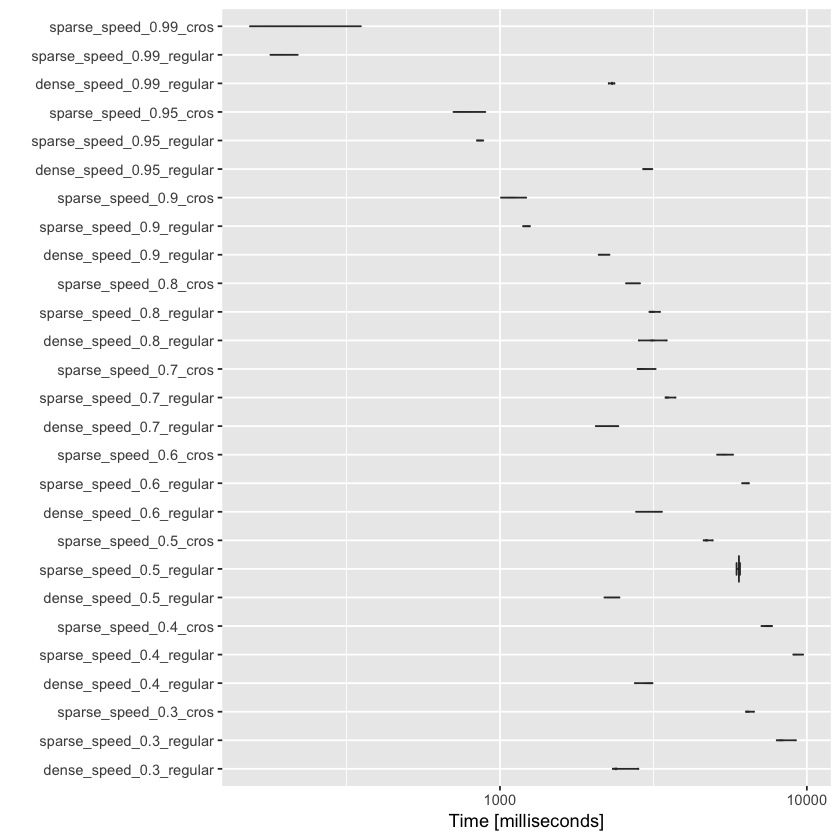

In [119]:
autoplot(susie_speed_all)

My analysis on Wednesday was wrong. After I took Matthew's advice to break susie into pieces and benchmarked each function, I noticed that in some functions, I need to transform the result of sparse matrix multiplication ('dgCMtrix' format) into 'Matrix' format to get other code work. In the main code of susie, to experiment the speed, I comment out X = scale(X, center=FALSE, scale=FALSE) since I noticed that even if I set both center and scale FALSE, the scale function always turns a sparse matrix into a dense matrix format.   

This is a benchmark comparison for the whole susie when I get rid of the scale function. I think peter is right. This is only worth doing when the sparsity is above 0.8. Is there any other insight? I am not very sure if this is what you expect in speaking of analysis?
